In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

C:\Users\Arjun\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# path of the current directory

# Save Intermediate Results? Otherwise going to load them
PRELOAD = True
SAVE = False

cur_dir = os.getcwd()
data_path = cur_dir+"/drugsCom"
train_path = data_path + "/drugsComTrain_raw.tsv"
test_path = data_path + "/drugsComTest_raw.tsv"
fda_path = data_path + "/drugs_recalls_fda.tsv"

fda = pd.read_csv(fda_path, sep='\t')
if PRELOAD:
    whole = pd.read_table("whole_sentiment_dataset.csv", sep=',')
else:
    train = pd.read_table(train_path, sep='\t')
    test = pd.read_table(test_path, sep='\t')    
    whole = pd.concat([train, test], ignore_index=True)

In [3]:
# Add review features from 1.2.data_preparation_drugscom to whole
import os
import pandas as pd
import numpy as np

import dateparser

from bs4 import BeautifulSoup  
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

def parse_condition(string):
    if np.isnan(string):
        return ""
    if "</span>" in string:
        return ""
    if "not listed" in string:
        return ""
    if len(string) < 4:
        return ""
    if '(' in string and (not ')' in string):
        return string.strip('( ').lower()
    if (not '(' in string) and ')' in string:
        return string.strip(') ').lower()
    return string.lower()

# Convert a raw review to a cleaned review
def cleanText(raw_text, remove_stopwords=True, stemming=False, split_text=True):    
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
        # Stemmers remove morphological affixes from words, leaving only the word stem.
        # http://www.nltk.org/howto/stem.html
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return(" ".join(words))

def average_word_length(list_of_words, is_list = True):
    if is_list == True:
        if type(list_of_words) != list:
            list_of_words = list(list_of_words)
        if list_of_words == []:
            return 0
        res = 0
        count = len(list_of_words)
        for item in list_of_words:
            res += len(item)
        return res/count
    list_of_words = list_of_words.split(' ')
    return average_word_length(list_of_words, is_list = True)

def construct_df(drugsCom):
    drugsCom['date'] = drugsCom['date'].apply(lambda x: pd.Timestamp(dateparser.parse(x), unit = 'D'))
    
    if 'partial_name' not in drugsCom.columns:
        drugsCom['partial_name'] = drugsCom['drugName'].apply(lambda x: x.split('/')[0].strip().lower())
    if 'is_recalled' not in drugsCom.columns:
        drugsCom['is_recalled'] = drugsCom['partial_name'].apply(lambda x: fda['Product Description'].str.contains(x, case=False, regex=False).any())
    
    drugsCom['condition'] = drugsCom['condition'].fillna(' ')
    drugsCom['condition'] = drugsCom['condition'].apply(lambda x: x.lower().strip())
    
    drugsCom['review_length'] = drugsCom['review'].apply(len)
    drugsCom['review_word_count'] = drugsCom['review'].apply(lambda x: len(x.split(' ')))
    
    drugsCom['cleaned_words'] = drugsCom['review'].apply(lambda x: cleanText(x, remove_stopwords=True, stemming=False, split_text=True))
    drugsCom['review_cleaned_word_count'] = drugsCom['cleaned_words'].apply(len)
    
    drugsCom['review_avg_word_length'] = drugsCom['review'].apply(lambda x: average_word_length(x, is_list = False))
    drugsCom['review_avg_cleaned_word_length'] = drugsCom['cleaned_words'].apply(lambda x: average_word_length(x, is_list = True))
    return drugsCom

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# setup Y for CNN
if not PRELOAD:
    whole = construct_df(whole)
#     whole['partial_name'] = whole['drugName'].apply(lambda x: x.split('/')[0].strip().lower())
#     whole['is_recalled'] = whole['partial_name'].apply(lambda x: fda['Product Description'].str.contains(x, case=False, regex=False).any())
    whole['is_recalled'] = whole['is_recalled'].astype(int)

print(whole['is_recalled'].sum())
print(whole.shape)    
whole.head()

22693
(215063, 19)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,drugName,condition,review,rating,date,usefulCount,partial_name,is_recalled,Sentimental_Polarity,Sentimental_Subjectivity,review_length,review_word_count,cleaned_words,review_cleaned_word_count,review_avg_word_length,review_avg_cleaned_word_length
0,0,0,206461,Valsartan,left ventricular dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27,valsartan,1,0.000000,0.000000,79,17,"['side', 'effect', 'take', 'combination', 'bys...",8,3.705882,5.250000
1,1,1,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192,guanfacine,0,0.188021,0.482812,742,141,"['son', 'halfway', 'fourth', 'week', 'intuniv'...",65,4.269504,5.630769
2,2,2,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17,lybrel,0,0.138485,0.327475,756,133,"['used', 'take', 'another', 'oral', 'contracep...",69,4.691729,5.637681
3,3,3,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,2015-11-03,10,ortho evra,0,0.357143,0.607143,448,89,"['first', 'time', 'using', 'form', 'birth', 'c...",39,4.044944,5.282051
4,4,4,35696,Buprenorphine / naloxone,opiate dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37,buprenorphine,0,0.172333,0.389667,719,134,"['suboxone', 'completely', 'turned', 'life', '...",59,4.373134,6.355932


In [5]:
# Setup Sentiment Feature Construction
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

import sqlite3
import pandas as pd
import random
import re
random.seed(1)
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from textblob import Word

import string
from time import time

from bs4 import BeautifulSoup  
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

verb_exp = ['VB', 'VBZ', 'VBP', 'VBD','VBN','VBG']
#porter_stemmer = PorterStemmer()
def clean_text(row):
    soup = BeautifulSoup(row, 'html.parser')
    #remove code
    for tag in soup.find_all('code'):
        tag.replaceWith(' ')
        
    raw = soup.get_text()
    #remove link
    raw_no_link = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', raw)
    #remove email
    no_link_email = re.sub(r'[\w\.-]+@[\w\.-]+[\.][com|org|ch|uk]{2,3}', "", raw_no_link)
    #remove whitespace
    tab_text = '\t\n\r\x0b\x0c'
    no_link_email_space = "".join([ch for ch in no_link_email if ch not in set(tab_text)])
    #remove fomula
    reg = '(\$.+?\$)|((\\\\begin\{.+?\})(.+?)(\\\\end\{(.+?)\}))'
    raw = re.sub(reg, "", no_link_email_space, flags=re.IGNORECASE)   
    return(raw)

def lem_stop(row):
    row = row.lower()
    #remove numbers
    raw = re.sub('[0-9]+?', ' ', row) 
    # remove punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    raw = regex.sub(' ', raw)
    #clean out the characters left out after the above step, like we’re, I’m, It’s, i.e.
    raw = re.sub('( s )|( re )|( m )|( i e )',' ',raw) 
    # lementize
    row_t = TextBlob(raw)
    raw = []
    for word, pos in row_t.tags:
        if pos in verb_exp:
            word = Word(word)
            word = word.lemmatize("v")
        else:
            word = Word(word)
            word = word.lemmatize()
        raw.append(word)
    clean = ' '.join(raw)      
    stop_words = set(stopwords.words('english'))
    # remove stop words
    cleaned_text = " ".join([word for word in word_tokenize(clean) if word not in stop_words])      
    return(cleaned_text)

def sentiment_ana(i):
    i_tr = TextBlob(i)
    return(i_tr.sentiment[0], i_tr.sentiment[1])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\Arjun\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
# Constructing Sentiment Features here
# why is this done??
# documents = whole['review'].values
# documents_train, documents_test = train_test_split(documents, test_size = 0.2, random_state = 42)
if not PRELOAD:
    # get the clean review
    review_rm = whole['review'].map(lambda i: clean_text(i))
    review_clean = review_rm.map(lambda i: lem_stop(i))
    sentiment = review_clean.map(lambda i: sentiment_ana(i))
    senti_pol, senti_sub = [list(t) for t in zip(*sentiment)]

    print(review_clean.shape)
    print(len(whole['review']))

    whole['Sentimental_Polarity'] = senti_pol
    whole['Sentimental_Subjectivity'] = senti_sub

if SAVE:
    whole.to_csv('whole_sentiment_dataset.csv')

In [4]:
# No missing values
whole = whole[['review', "rating", "usefulCount", "review_length", "review_word_count", "cleaned_words","review_cleaned_word_count", 
               "review_avg_word_length", "review_avg_cleaned_word_length",
               "Sentimental_Subjectivity", "Sentimental_Polarity", "is_recalled"]]

assert(whole.isnull().values.any() == False)
X = whole.iloc[:, 0:whole.shape[1]-1]
y = whole.iloc[:, whole.shape[1]-1]
print(y.head())
print(X.head())
y= y.values.reshape([-1, 1])

0    1
1    0
2    0
3    0
4    0
Name: is_recalled, dtype: int64
                                              review  rating  usefulCount  \
0  "It has no side effect, I take it in combinati...     9.0           27   
1  "My son is halfway through his fourth week of ...     8.0          192   
2  "I used to take another oral contraceptive, wh...     5.0           17   
3  "This is my first time using any form of birth...     8.0           10   
4  "Suboxone has completely turned my life around...     9.0           37   

   review_length  review_word_count  \
0             79                 17   
1            742                141   
2            756                133   
3            448                 89   
4            719                134   

                                       cleaned_words  \
0  ['side', 'effect', 'take', 'combination', 'bys...   
1  ['son', 'halfway', 'fourth', 'week', 'intuniv'...   
2  ['used', 'take', 'another', 'oral', 'contracep...   
3  ['first'

202421    ['medication', 'work', 'gave', 'pretty', 'both...
51535     ['used', 'etodolac', 'many', 'years', 'take', ...
18453     ['years', 'old', 'diagnosed', 'january', 'th',...
160981    ['got', 'kyleena', 'inserted', 'last', 'week',...
46276     ['fibromyalgia', 'years', 'diagnosed', 'year',...
Name: cleaned_words, dtype: object

In [8]:
# Setup tfid Word Vectors on training set with recalls
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)
print(X_train['cleaned_words'].head())
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train['cleaned_words'])
X_train_vectorized = vect.transform(X_train['cleaned_words'])
len(vect.get_feature_names())


190617

In [10]:
feature_names = np.array(vect.get_feature_names())
sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
print('Smallest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest Tfidf: \n{}\n'.format(feature_names[sorted_tfidf_index[:-11:-1]]))


Smallest Tfidf: 
['love lunesta' 'pill however' 'pill huge' 'pill husband' 'pill im'
 'pill immediately' 'pill implanon' 'pill implant' 'pill important'
 'pill improved']

Largest Tfidf: 
['spray' 'pill' 'skin' 'implant' 'iud' 'plan' 'withdrawals' 'suboxone'
 'mg' 'pain']



In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test['cleaned_words']))
print('AUC: ', roc_auc_score(y_test, predictions))


C:\Users\Arjun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC:  0.5431996641068912


Test Accuracy: 0.8526158571811021
Normalized confusion matrix
[[0.94 0.06]
 [0.85 0.15]]


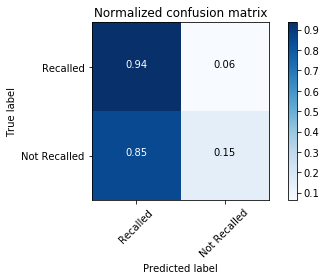

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Test model and check accuracy
acc_pred = accuracy_score(y_test, predictions)

print('Test Accuracy:', acc_pred)
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
class_names = ['Recalled', 'Not Recalled']
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True, classes=class_names, title='Normalized confusion matrix')